# 简介

在这个Notebook里面，我将尝试利用现有技术实现一个基于Transformer的入侵检测系统并尽可能对其进行改进。首先，我将描述本架构的各个组成部分，在阐明其原理后对模型进行训练与评估，并在最后在相同问题下将该架构与其他架构进行对比。

以下是为训练此模型而导入的包：

In [1]:
!pip install einops
# !pip install vaex
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install imbalanced-learn
!pip install rtdl_num_embeddings

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 701.5 kB/s eta 0:00:00


以下代码用于挂载google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 结构

## 嵌入(Embedding)

在该部分里，数值信息将被转换为可被Transformer识别的特征值并提供给后面的结构进行学习。

$$ReLU(Linear(Periodic(x_i)))$$

In [3]:
from torch import nn
import torch
# from einops import rearrange
from rtdl_num_embeddings import PeriodicEmbeddings

class Embedder(nn.Module):
    def __init__(self, dim, num_numerical_types=10):
        super().__init__()
        # self.weights = nn.Parameter(torch.randn(num_numerical_types, dim))
        # self.biases = nn.Parameter(torch.randn(num_numerical_types, dim))
        self.embeddings = PeriodicEmbeddings(num_numerical_types, dim, lite=False)

    def forward(self, x):
        # x = rearrange(x, 'b n -> b n 1')
        # return x * self.weights + self.biases
        return self.embeddings(x)

## 位置编码(Positional Encoding)

由于嵌入产生的信息并不带有位置信息，故需要在学习前将位置信息写入训练数据中。

$$PE(pos, 2i) = \sin(pos/1000^{2i/d\_model})$$
$$PE(pos, 2i+1) = \cos(pos/1000^{2i/d\_model})$$

In [4]:
import torch
from torch import nn
from torch.autograd import Variable
from math import cos, sin, sqrt

class Positional_Encoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 10):
        super().__init__()
        self.d_model = d_model

        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0,d_model,2):
                pe[pos,i] = sin(pos / (1000**(i/d_model)))
                pe[pos,i+1] = cos(pos / (1000**(i/d_model)))

        pe = pe.unsqueeze(0)
        self.register_buffer("pe",pe)

    def forward(self, x):
        x = x * sqrt(self.d_model)
        seq_len = x.size(1)
        y = Variable(self.pe[:,:seq_len],requires_grad=False).cuda()
        x = x + y
        return x

## 注意力机制(Attention)

本部分用于对输入向量进行处理以获取输入与输出间的对应关系。具体计算过程如下：

$$Attention(Q,K,V) = softmax\left(M+\frac{QK^T}{\sqrt{d_k}}\right)$$

In [5]:
import torch
from torch import nn
from torch.nn import functional as F
import math

def attention(q, k, v, d_k, mask=None, dropout=None):
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    if mask is not None:
      shape = scores.shape
      mask = get_mask(shape[0], 8, 10)
      scores = scores.masked_fill(mask == 0, -1e9)
    scores = F.softmax(scores, dim=-1)

    if dropout is not None:
        scores = dropout(scores)

    output = torch.matmul(scores, v)
    return output

class Multi_Head_Attention(nn.Module):
    def __init__(self, heads, d_model, dropout):
        super().__init__()
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):

        bs = q.size(0)

        # perform linear operation and split into h heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        # transpose to get dimensions bs * h * sl * d_model
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)

        scores = attention(q, k, v, self.d_k, mask, self.dropout)

        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)

        output = self.out(concat)
        return output


## 掩蔽(Masks)

该部分用于对输入解码器(Decoder)的向量进行掩蔽来使得解码器能够根据上下文来推算结果。

In [6]:
import numpy as np
import torch
from torch.autograd import Variable

def get_mask(batch_size, heads, seq_size):
    mask_prob = 0.2
    mask = torch.rand((batch_size, heads, seq_size, seq_size)) > mask_prob
    return mask.cuda()

## 前馈网络(Feed-Forward Network)

该部分主要用于记忆注意力机制计算所产生的的关系。具体原理如下：

$$FFN(x) = \max(0,xW_1 + b_1)W_2 + b_2$$

In [7]:
from torch import nn
from torch.nn import functional as F

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=1024, dropout = 0.1):
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

## 层归一化(Layer Norm)

主要用于使不同范围的数据归一化到[0, 1]区间内，方便模型进行处理，具体原理如下：

$$LN(x) = \frac{x - \mu}{\delta}\cdot \alpha + \beta$$

In [8]:
from torch import nn
import torch

class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()

        self.size = d_model

        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

## 编码器(Encoder)

整个编码器由数个编码器嵌入器、数个编码器层与层归一化层组成。其中，一个编码器层由层归一化、注意力机制与前馈神经网络层组成，数据在经过这些处理后由dropout方法进行输出。

In [9]:
from torch import nn
import copy

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Encoder_Layer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = Multi_Head_Attention(heads, d_model, dropout)
        self.feedf = FeedForward(d_model).cuda()
        self.dropout_1 = nn.Dropout(dropout).cuda()
        self.dropout_2 = nn.Dropout(dropout).cuda()

    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.feedf(x2))
        return x

class Encoder(nn.Module):
    def __init__(self, d_model, N, heads, dropout = 0.1):
        super().__init__()
        self.N = N
        self.embed = Embedder(d_model)
        self.pe = Positional_Encoder(d_model)
        self.layers = get_clones(Encoder_Layer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)

    def forward(self, src, mask = None):
        x = self.embed(src)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x,mask)
        return self.norm(x)

## 解码器

In [10]:
import torch
from torch import nn
import copy

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Decoder_Layer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        self.attn = Multi_Head_Attention(heads, d_model, dropout)
        self.msk_attn = Multi_Head_Attention(heads, d_model, dropout)
        self.feedf = FeedForward(d_model).cuda()
        self.dropout_1 = nn.Dropout(dropout).cuda()
        self.dropout_2 = nn.Dropout(dropout).cuda()
        self.dropout_3 = nn.Dropout(dropout).cuda()

    def forward(self, x, e_outputs, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.msk_attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.attn(x2,e_outputs,e_outputs,mask=None))
        x2 = self.norm_3(x)
        x = x +self.dropout_3(self.feedf(x2))
        return x

class Decoder(nn.Module):
    def __init__(self, d_model, N, heads, dropout = 0.1):
        super().__init__()
        self.N = N
        self.embed = Embedder(d_model)
        self.pe = Positional_Encoder(d_model,1)
        self.layers = get_clones(Decoder_Layer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)

    def forward(self, trg, e_outputs, mask = None):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x,e_outputs,mask)
        return self.norm(x)


## 整体架构定义

In [11]:
import torch
from torch import nn

class Transformer(nn.Module):
    def __init__(self, trg_vocab, d_model, N, heads, dropout = 0.1):
        super().__init__()
        self.encoder = Encoder(d_model, N , heads, dropout)
        self.decoder = Decoder(d_model, N , heads, dropout)
        self.out = nn.Linear(10*d_model, trg_vocab)

    def forward(self, src, trg_mask=None):
        e_outputs = self.encoder(src, None)
        d_output = self.decoder(src, e_outputs, trg_mask)
        d_intermediate = d_output.view(d_output.size(0), -1)
        output = self.out(d_intermediate)
        output = torch.softmax(output,dim=1)
        return output

# 数据集与数据处理

## NF-UNSW-NB15-v2
下载数据集:https://rdm.uq.edu.au/files/8c6e2a00-ef9c-11ed-827d-e762de186848

UNSW-NB15数据集的基于NetFlow的格式，命名为NF-UNSW-NB15，已经通过添加额外的NetFlow特征进行了扩展，并标记了其相应的攻击类别。数据流的总数为2,390,275，其中95,053（3.98%）是攻击样本，2,295,222（96.02%）是良性样本。

## 数据处理
本部分用于对数据进行预处理。由于本数据集的特殊性——正常流量远多于异常攻击流量，因此需要对数据进行下采样与ADASYN处理，前者用于限制数量较多的样本的数量，后者用于对数量较少的样本进行插值处理以增加其数量。

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

label_mapping = {}
directory_path = 'drive/MyDrive/Colab Notebooks/CIC-ToN-IoT/data/'


class UNSWDataset(Dataset):
    def __init__(self, data):
        self.features = data[:, :-3]  # Feature Columns
        self.at_type = data[:, -3]  # Attack Type Column
        self.labels = data[:, -2:]  # 1 Hot Encoded Label

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feature = torch.from_numpy(self.features[idx]).float()
        label = self.labels[idx]
        at_type = self.at_type[idx]

        return feature, label, at_type

def load_data():
    if os.path.exists(directory_path + "preprocessed/data.csv.gz"):
        print("Loading Preprocessed Data")
        data = pd.read_csv(directory_path + 'preprocessed/data.csv.gz', compression='gzip')

    else:
        chunk_size = 100000
        chunks = pd.read_csv(directory_path + 'CIC-ToN-IoT.csv.gz', chunksize=chunk_size, compression='gzip')
        max_float64 = np.finfo(np.float64).max

        dataframes = []
        for chunk in chunks:
            chunk.drop(chunk.columns[[0, 1, 3, 6]], axis=1, inplace=True)
            chunk.rename(columns={'Attack': 'Attack_type'}, inplace=True)
            chunk.columns = chunk.columns.str.strip()
            chunk = chunk.dropna()

            feature_chunk = chunk.drop(columns=['Label', 'Attack_type'])
            numeric_columns = feature_chunk.select_dtypes(include=[np.number]).columns
            feature_chunk[numeric_columns] = np.minimum(feature_chunk[numeric_columns], max_float64)
            labels_chunk = chunk[['Label', 'Attack_type']]
            chunk = pd.concat([feature_chunk, labels_chunk], axis=1)
            dataframes.append(chunk)
        data = pd.concat(dataframes, ignore_index=True)

        label_counts = data['Attack_type'].value_counts()
        print(label_counts)

        # data = data.dropna()

        # features = data.drop(columns=['Label', 'Attack'])
        # features = features.where(features <= max_float64, max_float64)
        # labels = data['Label']
        # data = pd.concat([features, labels], axis=1)

        # Undersampling & SMOTE

        max_class_size = 100000  # Size of all Classes for Undersampling
        class_counts = data['Attack_type'].value_counts()
        classes_to_undersample = class_counts[class_counts > max_class_size].index

        under_sampler = RandomUnderSampler(sampling_strategy={
            label: 7 * max_class_size if label == "Benign" else max_class_size if label in classes_to_undersample else
            class_counts[label] for label in np.unique(data['Attack_type'])
        }, random_state=42)
        nn_estimator = NearestNeighbors(n_neighbors=5, n_jobs=-1)
        smote = SMOTE(sampling_strategy={
            label: 7 * max_class_size if label == "Benign" else max_class_size for label in np.unique(data['Attack_type'])
        }, k_neighbors=nn_estimator, random_state=42)
        scaler = MinMaxScaler()

        features = data.drop(columns=['Label', 'Attack_type'])
        labels = data['Attack_type']
        sampled_features, sampled_labels = under_sampler.fit_resample(features, labels)
        balanced_features, balanced_labels = smote.fit_resample(sampled_features, sampled_labels)
        scaled_data = scaler.fit_transform(balanced_features)

        data = pd.DataFrame(data=scaled_data, columns=features.columns)

        # Encode the actual Attack type for later analysis
        label_encoder = LabelEncoder()
        data['Attack_type'] = label_encoder.fit_transform(balanced_labels)
        label_mapping = dict(enumerate(label_encoder.classes_))

        # 1 Hot Encoding
        data['Attack_Label'] = data['Attack_type'].apply(lambda x: "Attack" if label_mapping[x] != "Benign" else "Benign")
        encoded_labels = pd.get_dummies(data['Attack_Label'], prefix='', prefix_sep='')
        data = pd.concat([data, encoded_labels], axis=1)
        data.drop("Attack_Label", axis=1, inplace=True)

        features = data.drop(columns=['Attack_type', 'Attack', 'Benign'])
        labels = data[['Attack_type', 'Attack', 'Benign']]

        # PCA features extraction
        print('Using PCA...')
        scaler = StandardScaler()
        features = np.nan_to_num(scaler.fit_transform(features))
        pca = PCA(n_components=10, svd_solver='randomized')
        features = pd.DataFrame(pca.fit_transform(features))
        data = pd.concat([features, labels], axis=1)

        data.iloc[:, :10] = data.iloc[:, :10].astype('float64')
        data.iloc[:, -3:] = data.iloc[:, -3:].astype('int')

        label_counts = data['Attack_type'].value_counts()
        print(label_counts)
        if not os.path.exists(directory_path + 'preprocessed'):
            os.makedirs(directory_path + 'preprocessed')
        data.to_csv(directory_path + 'preprocessed/data.csv.gz', index=False, compression='gzip')
        print("saved")

    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
    train_data, val_data = train_data.values, val_data.values

    return train_data, val_data


def get_data_loader(data, batch_size):
    unsw_dataset = UNSWDataset(data)

    return DataLoader(unsw_dataset, batch_size=batch_size, shuffle=True)

# 模型训练

定义训练与评估函数

In [13]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import time
import os
import torch
from torch.nn import functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, r2_score, \
    mean_squared_error, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import ConfusionMatrixDisplay


def plot_metrics(losses, accs, pres, recs, aucs, f1s):
    epochs = range(1, len(losses) + 1)
    metrics = {'Loss': losses, 'Accuracy': accs, 'Precision': pres, 'Recall': recs, 'F1 Score': f1s}
    categories = list(metrics.keys())
    num_categories = len(categories)
    num_subplots_per_row = 3
    num_rows = (num_categories + num_subplots_per_row - 1) // num_subplots_per_row

    plt.figure(figsize=(16, 4 * num_rows))  # 调整图表大小以适应多子图

    for i, metric_name in enumerate(categories, start=1):
        plt.subplot(num_rows, num_subplots_per_row, i)
        plt.plot(epochs, metrics[metric_name], marker='o')
        plt.title(metric_name)
        plt.xlabel('Epoch')
        plt.ylabel(metric_name.replace(" ", "\n"))  # 分行显示标签，如果标签中有空格的话
        plt.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 自动调整子图间距，留出顶部标题空间
    plt.show()


def eval_model(model, loader):
    model.cuda()
    model.eval()
    losses = []
    correct = 0
    predictions = []
    targets = []

    with torch.no_grad():
        for data, target, _ in loader:
            data, target = data.to("cuda"), target.to("cuda")
            output = model(data)
            loss = F.cross_entropy(output, target).item()
            losses.append(loss)
            pred = torch.argmax(output, dim=1)
            correct += torch.eq(torch.argmax(output, dim=1),torch.argmax(target, dim=1)).cpu().sum().item()
            predictions.extend(pred.cpu().numpy())
            targets.extend(target.cpu().numpy())

    eval_loss = np.mean(losses)
    eval_acc = correct / len(loader.dataset)
    targets = torch.tensor(targets)

    # 计算精确率、召回率、F1 分数
    precision = precision_score(torch.argmax(targets, dim=1), predictions, average='macro')
    recall = recall_score(torch.argmax(targets, dim=1), predictions, average='macro')
    f1 = f1_score(torch.argmax(targets, dim=1), predictions, average='macro')

    # 计算 ROC 曲线和 AUC
    try:
        auc = roc_auc_score(torch.argmax(targets, dim=1), predictions, average='weighted')
    except ValueError:
        auc = None

    # 计算混淆矩阵
    conf_matrix = confusion_matrix(torch.argmax(targets, dim=1), predictions)

    # 计算 R-squared
    r_squared = r2_score(torch.argmax(targets, dim=1), predictions)

    # 计算均方误差
    mse = mean_squared_error(torch.argmax(targets, dim=1), predictions)

    # 计算对数损失
    try:
        logloss = log_loss(torch.argmax(targets, dim=1), predictions)
    except ValueError:
        logloss = None

    print("Loss:", eval_loss, "Accuracy:", eval_acc)
    print("Precision:", precision, "Recall:", recall, "F1 Score:", f1)
    print("AUC:", auc)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("R-squared:", r_squared)
    print("Mean Squared Error:", mse)
    print("Log Loss:", logloss)

    return eval_loss, eval_acc, precision, recall, f1, auc, r_squared, mse, logloss, conf_matrix


def train_model(model, opt, epochs, data, eval_data, path, print_every=100):
    model.cuda()

    pretrained_path = "drive/MyDrive/Colab Notebooks/CIC-ToN-IoT/pretrained"
    top_acc = 0.
    scheduler = StepLR(opt, step_size=1, gamma=0.9)

    if os.path.exists(pretrained_path + "/" + path):
        print("Loading Pretrained Model")
        state = torch.load(pretrained_path + "/" + path)
        model.load_state_dict(state["model_state_dict"])
        start_epoch = state["epoch"] + 1
        losses = state["ep_loss"]
        accs = state["ep_acc"]
        top_acc = max(accs)
        aucs = state["aucs"]
        f1s = state['f1s']
        recs = state['recs']
        pres = state['pres']
        conf_matrix = state['conf_matrix']
    else:
        start_epoch = 0
        losses, accs = [], []
        aucs = []
        f1s = []
        recs = []
        pres = []
        try:
            os.mkdir(pretrained_path)
        except OSError as error:
            pass

    start = time.time()
    temp = start

    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0
        for i, batch in enumerate(data):
            src, trg, _ = batch
            src, trg = src.cuda(), trg.cuda()

            if isinstance(model, Transformer):
                trg_mask = get_mask(128, 8, 10)
            else:
                trg_mask = None

            preds = model(src, trg_mask)
            opt.zero_grad()
            loss = F.cross_entropy(preds, trg)
            loss.backward()
            opt.step()
            scheduler.step()

            total_loss += loss.data
            if (i + 1) % print_every == 0:
                loss_avg = total_loss / print_every
                print("time = %dm, epoch %d, iter = %d, loss = %.3f, \
                %ds per %d iters" % ((time.time() - start) // 60,
                                     epoch + 1, i + 1, loss_avg, time.time() - temp,
                                     print_every))
                total_loss = 0
                temp = time.time()
        eval_loss, eval_acc, precision, recall, f1, auc, r_squared, mse, logloss, conf_matrix = eval_model(model, eval_data)
        losses.append(eval_loss)
        accs.append(eval_acc)
        pres.append(precision)
        recs.append(recall)
        aucs.append(auc)
        f1s.append(f1)

        plot_metrics(losses, accs, pres, recs, aucs, f1s)

        if eval_acc > top_acc:
            top_state = {
              'model_state_dict': model.state_dict(),
              'epoch': epoch,
              'ep_loss': losses,
              'ep_acc': accs,
              'pres': pres,
              'recs': recs,
              'f1s': f1s,
              'aucs': aucs,
              'conf_matrix': conf_matrix
            }
            torch.save(top_state, pretrained_path + "/max_" + path)
        state = {
            'model_state_dict': model.state_dict(),
            'epoch': epoch,
            'ep_loss': losses,
            'ep_acc': accs,
            'pres': pres,
            'recs': recs,
            'f1s': f1s,
            'aucs': aucs,
            'conf_matrix': conf_matrix
        }
        torch.save(state, pretrained_path + "/" + path)

设置参数并训练模型

Loading Preprocessed Data
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Embedder-1               [-1, 10, 32]               0
Positional_Encoder-2               [-1, 10, 32]               0
              Norm-3               [-1, 10, 32]              32
            Linear-4               [-1, 10, 32]           1,056
            Linear-5               [-1, 10, 32]           1,056
            Linear-6               [-1, 10, 32]           1,056
           Dropout-7            [-1, 8, 10, 10]               0
            Linear-8               [-1, 10, 32]           1,056
Multi_Head_Attention-9               [-1, 10, 32]               0
          Dropout-10               [-1, 10, 32]               0
             Norm-11               [-1, 10, 32]              32
           Linear-12             [-1, 10, 1024]          33,792
          Dropout-13             [-1, 10, 1024]               0
           

<ipython-input-13-30443eaf7fbd>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  targets = torch.tensor(targets)


Loss: 0.36983363447114825 Accuracy: 0.943009375
Precision: 0.9514148988402866 Recall: 0.9357524802115149 F1 Score: 0.9411738879217304
AUC: 0.9357524802115149
Confusion Matrix:
[[179144   1391]
 [ 16846 122619]]
R-squared: 0.7682195856263214
Mean Squared Error: 0.056990625
Log Loss: 2.0541503339291554


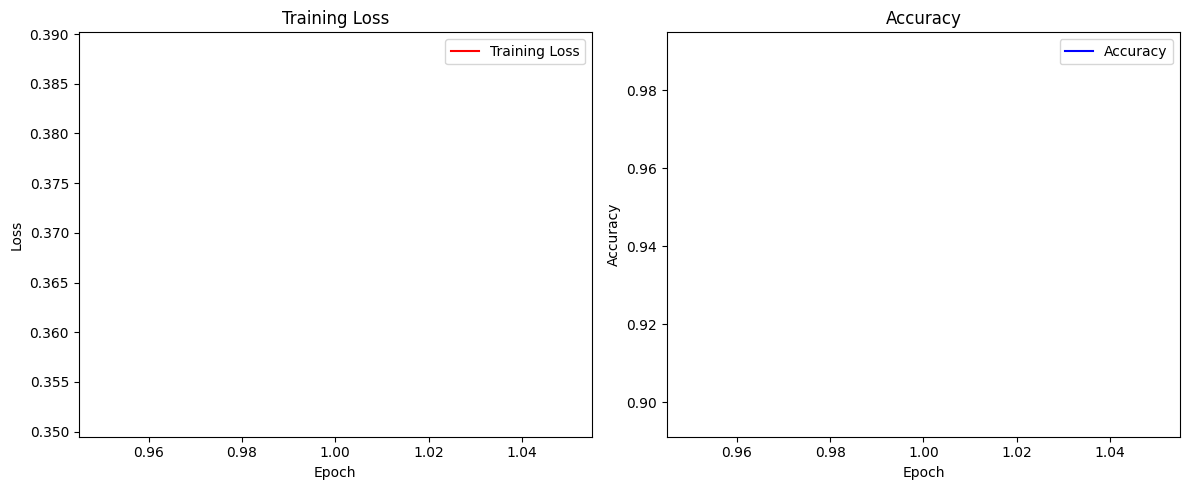

time = 7m, epoch 2, iter = 100, loss = 0.372,                 34s per 100 iters
time = 7m, epoch 2, iter = 200, loss = 0.376,                 7s per 100 iters
time = 7m, epoch 2, iter = 300, loss = 0.375,                 8s per 100 iters
time = 7m, epoch 2, iter = 400, loss = 0.372,                 7s per 100 iters
time = 7m, epoch 2, iter = 500, loss = 0.371,                 8s per 100 iters
time = 8m, epoch 2, iter = 600, loss = 0.371,                 8s per 100 iters
time = 8m, epoch 2, iter = 700, loss = 0.374,                 7s per 100 iters
time = 8m, epoch 2, iter = 800, loss = 0.371,                 8s per 100 iters
time = 8m, epoch 2, iter = 900, loss = 0.373,                 8s per 100 iters
time = 8m, epoch 2, iter = 1000, loss = 0.368,                 7s per 100 iters
time = 8m, epoch 2, iter = 1100, loss = 0.371,                 8s per 100 iters
time = 8m, epoch 2, iter = 1200, loss = 0.369,                 7s per 100 iters
time = 8m, epoch 2, iter = 1300, loss = 0.369,  

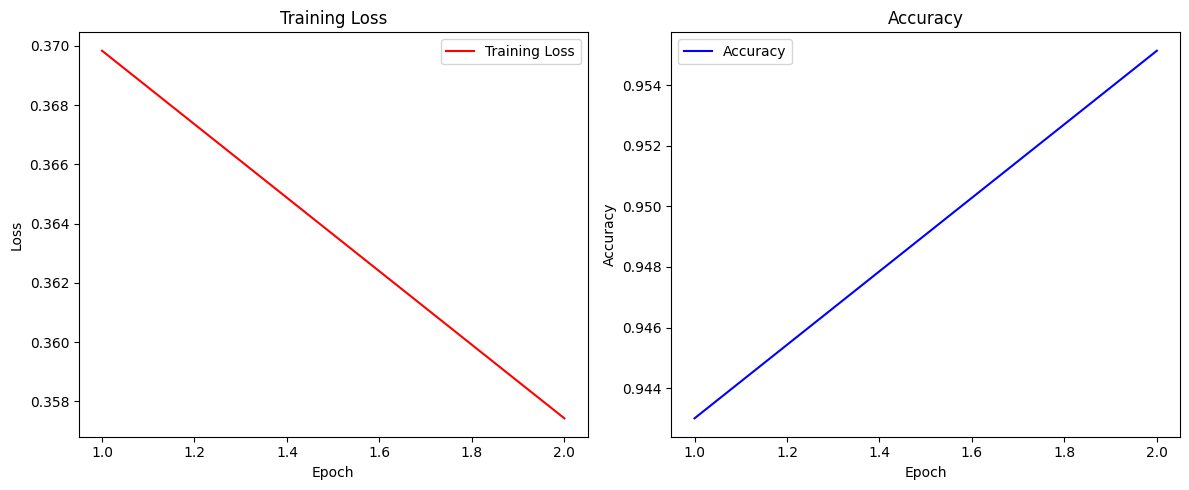

time = 14m, epoch 3, iter = 100, loss = 0.360,                 33s per 100 iters
time = 14m, epoch 3, iter = 200, loss = 0.362,                 7s per 100 iters
time = 14m, epoch 3, iter = 300, loss = 0.360,                 8s per 100 iters
time = 14m, epoch 3, iter = 400, loss = 0.362,                 7s per 100 iters
time = 15m, epoch 3, iter = 500, loss = 0.362,                 8s per 100 iters
time = 15m, epoch 3, iter = 600, loss = 0.360,                 8s per 100 iters
time = 15m, epoch 3, iter = 700, loss = 0.361,                 7s per 100 iters
time = 15m, epoch 3, iter = 800, loss = 0.362,                 8s per 100 iters
time = 15m, epoch 3, iter = 900, loss = 0.363,                 8s per 100 iters
time = 15m, epoch 3, iter = 1000, loss = 0.362,                 7s per 100 iters
time = 15m, epoch 3, iter = 1100, loss = 0.360,                 8s per 100 iters
time = 16m, epoch 3, iter = 1200, loss = 0.360,                 7s per 100 iters
time = 16m, epoch 3, iter = 1300, lo

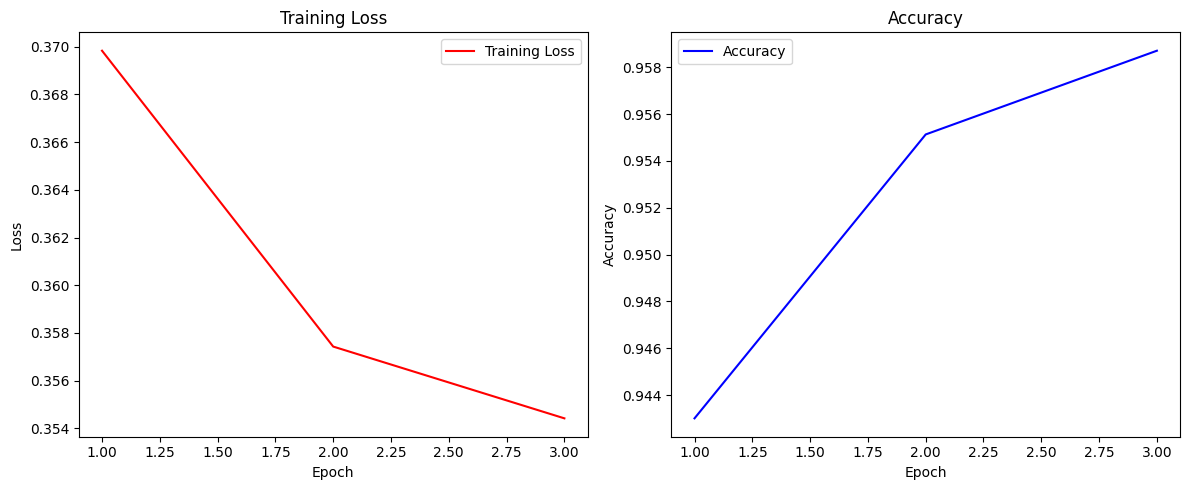

time = 21m, epoch 4, iter = 100, loss = 0.357,                 33s per 100 iters
time = 21m, epoch 4, iter = 200, loss = 0.356,                 8s per 100 iters
time = 21m, epoch 4, iter = 300, loss = 0.359,                 8s per 100 iters
time = 22m, epoch 4, iter = 400, loss = 0.356,                 7s per 100 iters
time = 22m, epoch 4, iter = 500, loss = 0.358,                 8s per 100 iters
time = 22m, epoch 4, iter = 600, loss = 0.359,                 8s per 100 iters
time = 22m, epoch 4, iter = 700, loss = 0.357,                 7s per 100 iters
time = 22m, epoch 4, iter = 800, loss = 0.359,                 8s per 100 iters
time = 22m, epoch 4, iter = 900, loss = 0.357,                 7s per 100 iters
time = 22m, epoch 4, iter = 1000, loss = 0.358,                 8s per 100 iters
time = 23m, epoch 4, iter = 1100, loss = 0.358,                 8s per 100 iters
time = 23m, epoch 4, iter = 1200, loss = 0.359,                 7s per 100 iters
time = 23m, epoch 4, iter = 1300, lo

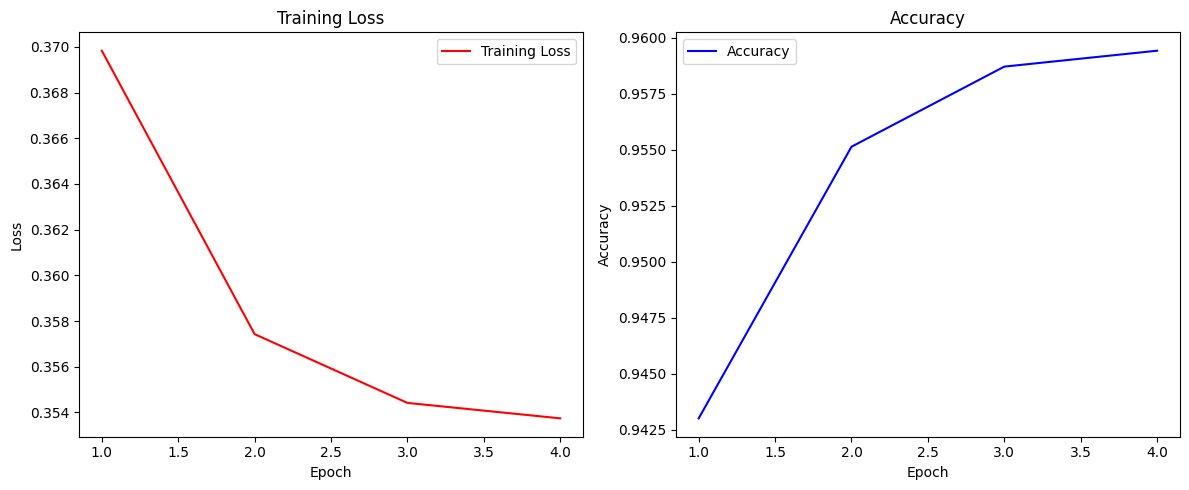

time = 28m, epoch 5, iter = 100, loss = 0.359,                 33s per 100 iters
time = 29m, epoch 5, iter = 200, loss = 0.357,                 8s per 100 iters
time = 29m, epoch 5, iter = 300, loss = 0.354,                 8s per 100 iters
time = 29m, epoch 5, iter = 400, loss = 0.357,                 7s per 100 iters
time = 29m, epoch 5, iter = 500, loss = 0.355,                 8s per 100 iters
time = 29m, epoch 5, iter = 600, loss = 0.354,                 7s per 100 iters
time = 29m, epoch 5, iter = 700, loss = 0.357,                 8s per 100 iters
time = 29m, epoch 5, iter = 800, loss = 0.357,                 8s per 100 iters
time = 29m, epoch 5, iter = 900, loss = 0.356,                 7s per 100 iters
time = 30m, epoch 5, iter = 1000, loss = 0.358,                 8s per 100 iters
time = 30m, epoch 5, iter = 1100, loss = 0.356,                 8s per 100 iters
time = 30m, epoch 5, iter = 1200, loss = 0.356,                 7s per 100 iters
time = 30m, epoch 5, iter = 1300, lo

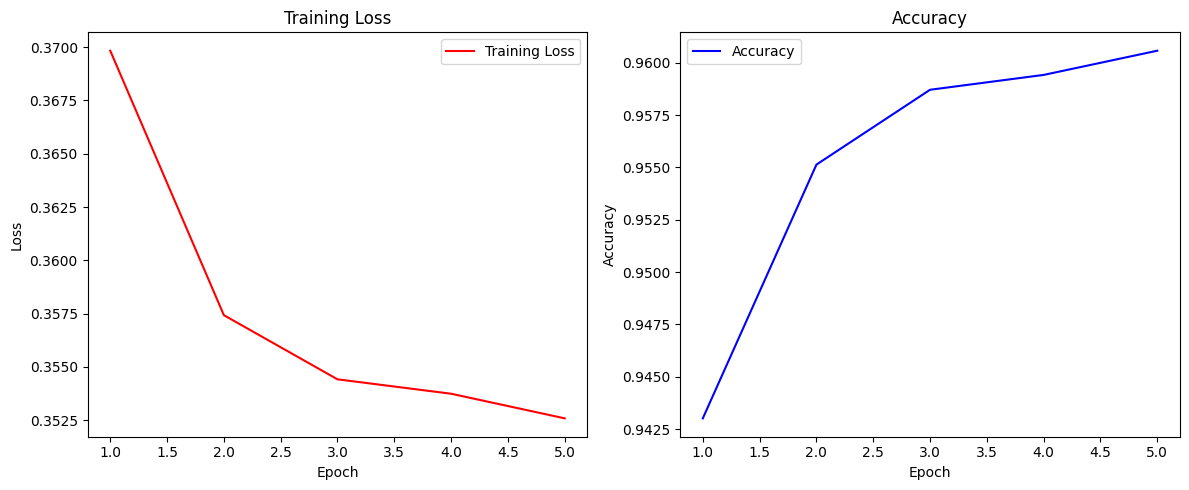

time = 36m, epoch 6, iter = 100, loss = 0.355,                 33s per 100 iters
time = 36m, epoch 6, iter = 200, loss = 0.358,                 8s per 100 iters
time = 36m, epoch 6, iter = 300, loss = 0.353,                 8s per 100 iters
time = 36m, epoch 6, iter = 400, loss = 0.356,                 7s per 100 iters
time = 36m, epoch 6, iter = 500, loss = 0.354,                 8s per 100 iters
time = 36m, epoch 6, iter = 600, loss = 0.356,                 7s per 100 iters
time = 36m, epoch 6, iter = 700, loss = 0.355,                 8s per 100 iters
time = 37m, epoch 6, iter = 800, loss = 0.357,                 8s per 100 iters
time = 37m, epoch 6, iter = 900, loss = 0.354,                 7s per 100 iters
time = 37m, epoch 6, iter = 1000, loss = 0.354,                 8s per 100 iters
time = 37m, epoch 6, iter = 1100, loss = 0.356,                 7s per 100 iters
time = 37m, epoch 6, iter = 1200, loss = 0.353,                 8s per 100 iters
time = 37m, epoch 6, iter = 1300, lo

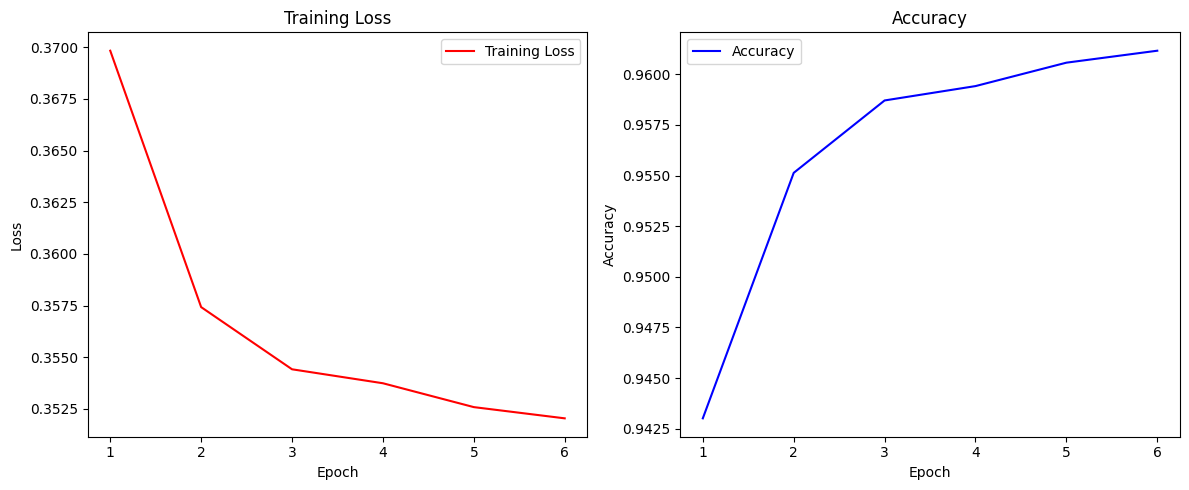

time = 43m, epoch 7, iter = 100, loss = 0.353,                 33s per 100 iters
time = 43m, epoch 7, iter = 200, loss = 0.354,                 8s per 100 iters
time = 43m, epoch 7, iter = 300, loss = 0.355,                 7s per 100 iters
time = 43m, epoch 7, iter = 400, loss = 0.354,                 8s per 100 iters
time = 43m, epoch 7, iter = 500, loss = 0.355,                 8s per 100 iters
time = 43m, epoch 7, iter = 600, loss = 0.354,                 7s per 100 iters
time = 44m, epoch 7, iter = 700, loss = 0.356,                 8s per 100 iters
time = 44m, epoch 7, iter = 800, loss = 0.354,                 8s per 100 iters
time = 44m, epoch 7, iter = 900, loss = 0.354,                 7s per 100 iters
time = 44m, epoch 7, iter = 1000, loss = 0.352,                 8s per 100 iters
time = 44m, epoch 7, iter = 1100, loss = 0.352,                 7s per 100 iters
time = 44m, epoch 7, iter = 1200, loss = 0.353,                 8s per 100 iters
time = 44m, epoch 7, iter = 1300, lo

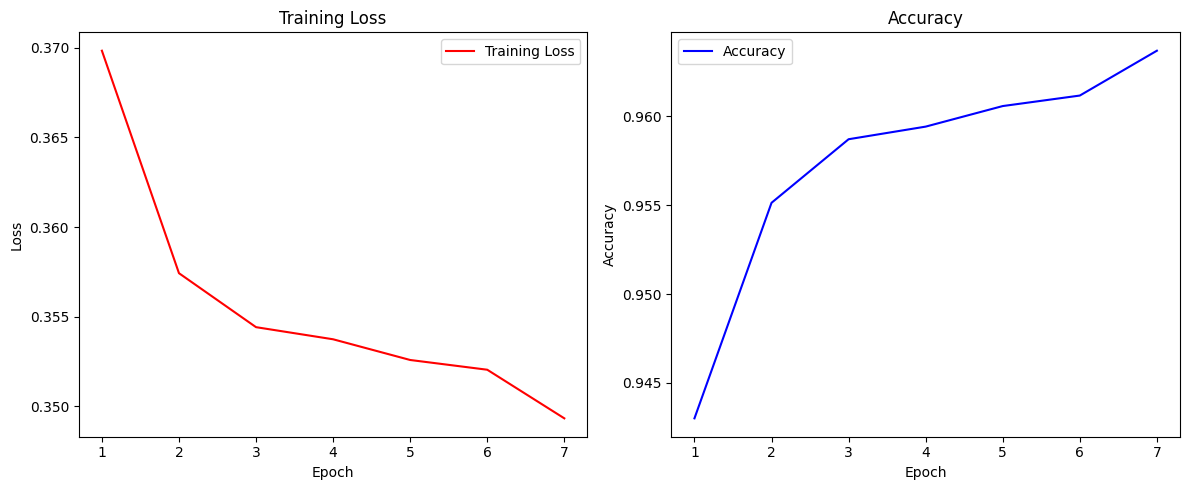

time = 50m, epoch 8, iter = 100, loss = 0.354,                 33s per 100 iters
time = 50m, epoch 8, iter = 200, loss = 0.352,                 8s per 100 iters
time = 50m, epoch 8, iter = 300, loss = 0.352,                 8s per 100 iters
time = 50m, epoch 8, iter = 400, loss = 0.353,                 7s per 100 iters
time = 51m, epoch 8, iter = 500, loss = 0.351,                 8s per 100 iters
time = 51m, epoch 8, iter = 600, loss = 0.351,                 7s per 100 iters
time = 51m, epoch 8, iter = 700, loss = 0.352,                 8s per 100 iters
time = 51m, epoch 8, iter = 800, loss = 0.352,                 8s per 100 iters
time = 51m, epoch 8, iter = 900, loss = 0.350,                 7s per 100 iters
time = 51m, epoch 8, iter = 1000, loss = 0.351,                 8s per 100 iters
time = 51m, epoch 8, iter = 1100, loss = 0.351,                 8s per 100 iters
time = 52m, epoch 8, iter = 1200, loss = 0.352,                 7s per 100 iters
time = 52m, epoch 8, iter = 1300, lo

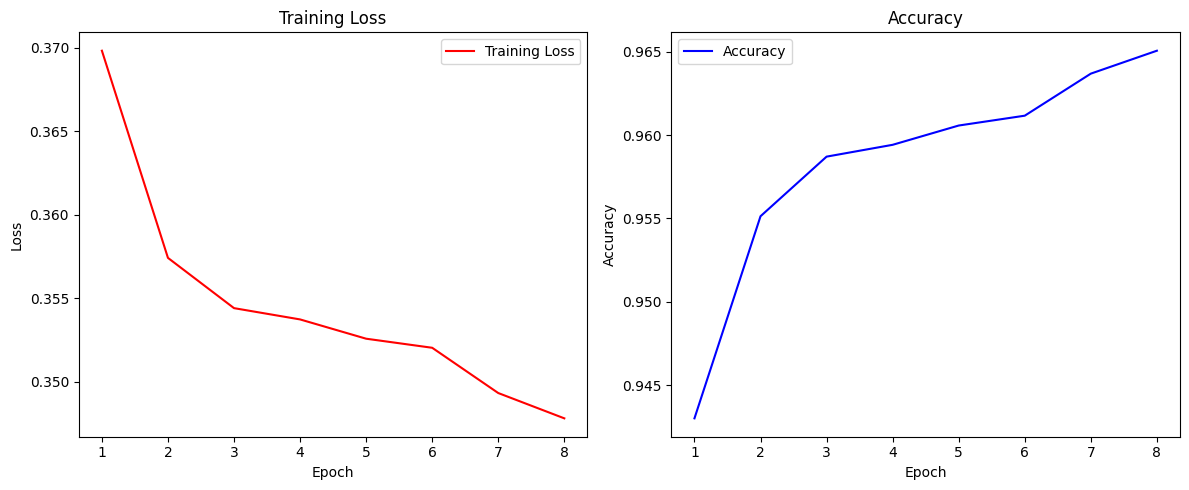

time = 57m, epoch 9, iter = 100, loss = 0.351,                 32s per 100 iters
time = 57m, epoch 9, iter = 200, loss = 0.350,                 8s per 100 iters
time = 58m, epoch 9, iter = 300, loss = 0.353,                 8s per 100 iters
time = 58m, epoch 9, iter = 400, loss = 0.351,                 7s per 100 iters
time = 58m, epoch 9, iter = 500, loss = 0.351,                 8s per 100 iters
time = 58m, epoch 9, iter = 600, loss = 0.349,                 8s per 100 iters
time = 58m, epoch 9, iter = 700, loss = 0.349,                 8s per 100 iters
time = 58m, epoch 9, iter = 800, loss = 0.349,                 8s per 100 iters
time = 58m, epoch 9, iter = 900, loss = 0.351,                 7s per 100 iters
time = 58m, epoch 9, iter = 1000, loss = 0.350,                 8s per 100 iters
time = 59m, epoch 9, iter = 1100, loss = 0.349,                 8s per 100 iters
time = 59m, epoch 9, iter = 1200, loss = 0.351,                 7s per 100 iters
time = 59m, epoch 9, iter = 1300, lo

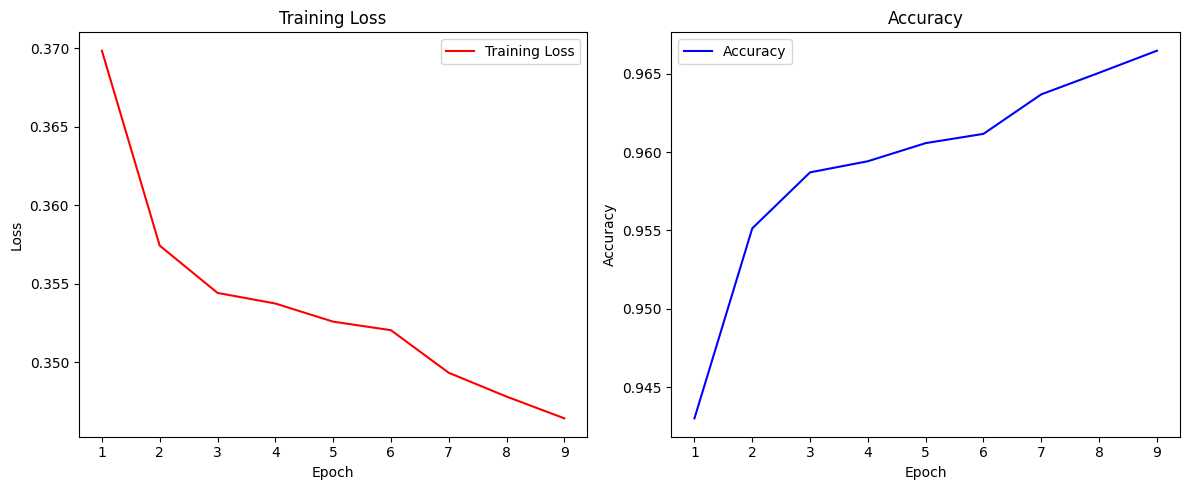

time = 65m, epoch 10, iter = 100, loss = 0.348,                 34s per 100 iters
time = 65m, epoch 10, iter = 200, loss = 0.350,                 7s per 100 iters
time = 65m, epoch 10, iter = 300, loss = 0.349,                 8s per 100 iters
time = 65m, epoch 10, iter = 400, loss = 0.349,                 8s per 100 iters
time = 65m, epoch 10, iter = 500, loss = 0.351,                 7s per 100 iters
time = 65m, epoch 10, iter = 600, loss = 0.349,                 8s per 100 iters
time = 65m, epoch 10, iter = 700, loss = 0.350,                 8s per 100 iters
time = 65m, epoch 10, iter = 800, loss = 0.350,                 7s per 100 iters
time = 66m, epoch 10, iter = 900, loss = 0.350,                 8s per 100 iters
time = 66m, epoch 10, iter = 1000, loss = 0.349,                 7s per 100 iters
time = 66m, epoch 10, iter = 1100, loss = 0.349,                 8s per 100 iters
time = 66m, epoch 10, iter = 1200, loss = 0.348,                 8s per 100 iters
time = 66m, epoch 10, it

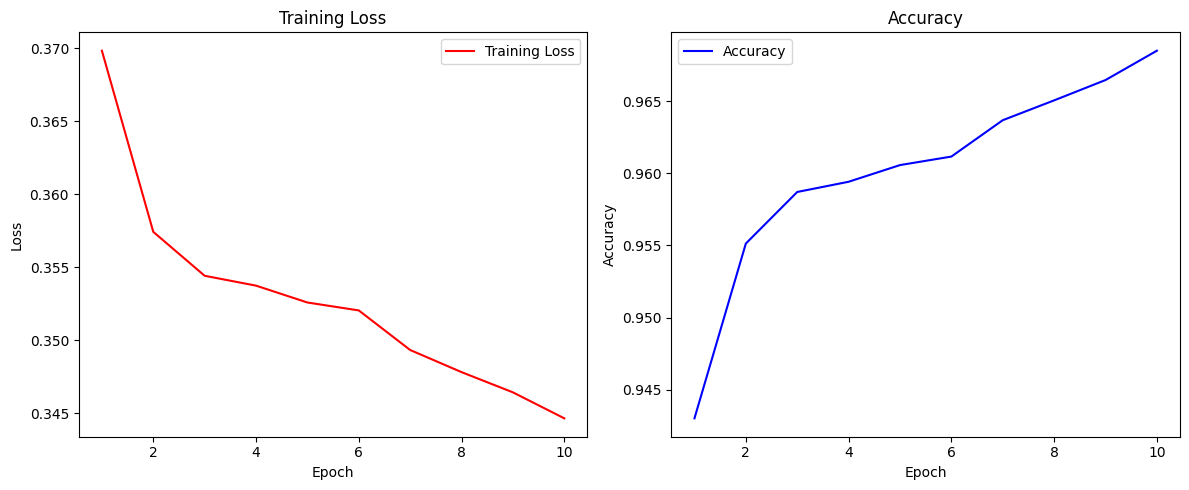

In [15]:
import torch
from torch import nn
from torchsummary import summary


learning_rate = 1e-5
batch_size = 256
epochs = 10
dropout_rate = 0.5
d_model = 32
heads = 8
N = 6
trg_vocab = 2

train_data, val_data = load_data()

train_loader = get_data_loader(train_data, batch_size)
val_loader = get_data_loader(val_data, batch_size)

model = Transformer(trg_vocab, d_model, N, heads, dropout_rate)
save_path = "pretrained.pt"

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to("cuda:0")
summary(model, (10, ))

optim = torch.optim.RAdam(model.parameters(), lr=learning_rate)

train_model(model, optim, epochs, train_loader, val_loader, save_path)